In [16]:
import numpy as np
import pandas as pd
import math
import scipy.stats
import matplotlib.pyplot as plt
import glob
import os
import re
from natsort import natsorted

plt.style.use('dark_background')

In [3]:
def expfit(D, x = None):
    S = [0]
    n = D.shape[0]
    if type(x) is np.ndarray:
        x = x.copy()
        x -= x[0]
    else:
        x = np.arange(n)
        
    for k in range(1, n):
        S.append(S[-1] + (D[k] + D[k - 1]) * (x[k] - x[k - 1]) / 2)

    S = np.array(S)

    A = [[np.sum(x ** 2), np.sum(x * S)],
        [np.sum(x * S), np.sum(S ** 2)]]
    B = [np.sum((D - D[0]) * x), np.sum((D - D[0]) * S)]
    [_, c] = np.linalg.solve(A, B)
    C = [[n, np.sum(np.exp(c * x))],
        [np.sum(np.exp(c * x)), np.sum(np.exp(2 * c * x))]]
    D_ = [np.sum(D), np.sum(D * np.exp(c * x))]
    [a, b] = np.linalg.solve(C, D_)
    
    return (a, b, c)

In [4]:
# alpha = -((amax / vmax) + b/m)
# beta = amax - F0 / m
# system: a = (1 - v / vmax) * amax - b' * v - F0'
# => a = -((amax / vmax) + b')*v + (amax - F0')
# => a = alpha * v + beta
# => v = k1*exp(alpha * t) - beta / alpha
# => v = B * exp(C * t) + A
# => 
# A -> -beta / alpha
# B -> ~= beta/alpha (due to v=0 @t=0)
# C -> alpha

52.704803933171696 0.002422205946623379 -0.2581333692295832
255.32374958972738 0.002535405482922517 -0.24068103862048645
438.2428617423166 0.002662389423605855 -0.25105537885638834
627.1855542247674 0.002691496169397976 -0.26806803317721634
778.0173157918928 0.002836877563500268 -0.27766077158086844
937.3579433339486 0.002909876075052838 -0.28530637395655345
1076.500820540671 0.003016631189682053 -0.29027707762104765
1210.8461910439182 0.0031114151778328654 -0.30341163297738016
1218.4220298230512 0.003514054465100201 -0.3400590366012687
-50.40448691130419 0.005558489629670196 -0.27428401565067834
-434.8678654582433 0.0029287511027474332 -0.25521162907777734
-757.3281735590516 0.003063257661542476 -0.27543184865375525
-1073.2317006735957 0.003135362495928448 -0.2892840919783739
-1213.110554742215 0.0036421715137511337 -0.33990292842512376


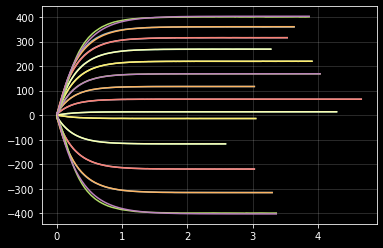

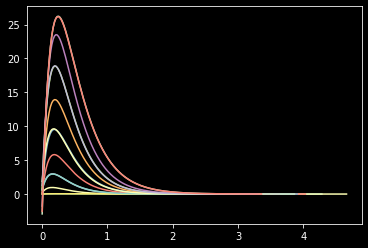

In [24]:
V0 = 7.6
IFLY = 0.0002193
fits = {}
for f in natsorted(glob.glob('20210926/*')):
    duty = int(os.path.basename(f))
        
    D = pd.read_csv(f, names=['t', 'speed', 'volts'])
    D = D[(D['speed'] * np.sign(duty)) > 0][:-2] # crop the last couple rows to avoid artifacts from buffering/stopping UART
    D['t'] -= D.iloc[0]['t']
    D['t'] /= 1E3 # convert to seconds
    
    if False:
        plt.figure(1)
        plt.plot(D['t'], D['speed'])

        plt.figure(2)
        plt.plot(D['t'], D['volts'])
        
    volt = duty / 256 * V0 * 1200 / 2048
    X = np.array(D['t'])
    V = np.array(D['speed'])
            
    t = expfit(V, X)
    fits[duty] = t
    (a, b, c) = t

    tau0 = b * c
    Ki = volt / (tau0 + F0)
    Kv = (volt - Ki * (B * a + F0)) / a

    print(tau0, Ki, 1/c)

    v_dyn = b * np.exp(c * X) + a
    tau_dyn = b * c * np.exp(c * X)
    volt_tau_dyn = volt - (Kv * v_dyn + Ki * (B * v_dyn + F0))
    if False:
        plt.plot(X, tau_dyn / volt_tau_dyn)

    if True:
        alpha = c
        beta = -a * c
        amax = beta + F0
        vmax = -amax / (alpha + B)

        vtheory = b * np.exp(c * X) + a
        atheory = (1 - V / vmax) * amax - F0 - B * V
        areal = (b * c * np.exp(c * X))

#                 plt.semilogy(X, areal / atheory)
        plt.figure(1)
        plt.grid(True, alpha=0.2)
        plt.plot(X, V)
        plt.plot(X, a + b * np.exp(c * X))
#                 plt.plot(X, )

        plt.figure(2)
        plt.plot(X, b * c * np.exp(c * X) * (b * np.exp(c * X) + a) * IFLY)

309.34128230282397 94.51878484348515 0.6535027719601386 19.10997942783497


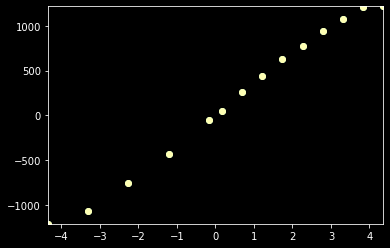

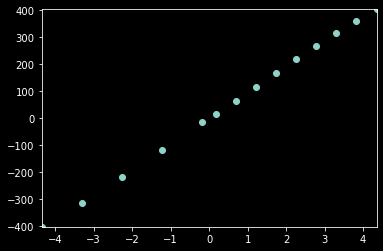

In [21]:
T0s = []
Vfs = []
Vs = []
for duty, (a, b, c) in fits.items():
    V = V0 * duty / 256 * 1200 / 2048
    # Ki.append(-a * c / V)
    T0s.append(b * c)
    Vfs.append(a)
    Vs.append(V)

Ki, F0 = np.polyfit(Vs, T0s, 1)
plt.scatter(Vs, T0s)
Kv, Kv0 = np.polyfit(Vs, Vfs, 1)
plt.scatter(Vs, T0s)
plt.xlim([np.amin(Vs), np.amax(Vs)])
plt.ylim([np.amin(T0s), np.amax(T0s)])
plt.figure()
plt.scatter(Vs, Vfs)
plt.xlim([np.amin(Vs), np.amax(Vs)])
plt.ylim([np.amin(Vfs), np.amax(Vfs)])
print(Ki, Kv, Kv0, F0)

25.651525158839696 0.0010568739463748436 -3.6405262042255826
52.5919408343695 0.0013730985806848649 -3.2551157489402076
90.1146372709532 0.001657294162678921 -2.6504021333177263
133.7816551807358 0.0019121571954296653 -2.220893847211954
184.428709219715 0.002135457250665821 -1.87108808195973
224.40564319966327 0.002360839331355995 -1.6856453726886844
274.653490151676 0.0025512448285949754 -1.5151306930058377


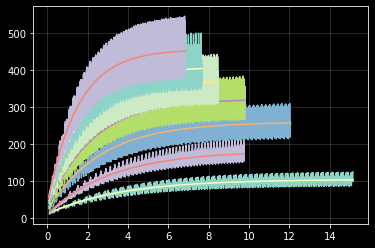

In [6]:
D = {}
SKIP = 1
TICK2RADS = 1E6 / 42 * math.pi * 2
V0 = 7.4

TIME_DOWNSAMPLING = 8

B = 1.5498
F0 = 1000 # 198.81 * B

for d in sorted(os.listdir('20210608/')):
    if os.path.isdir('20210608/%s' % d) and d[0] != '.':
        plt.figure()
        D[d] = {}
        for fn in sorted(os.listdir('20210608/%s' % d)):
            duty = int(fn)
            D_ = []
            with open('20210608/%s/%s' % (d, fn), 'r') as f:
                f.__next__()
                downsample = int(f.__next__())
                for l in f:
                    D_ += [int(a) for a in re.sub(r'[{}]', '', l.strip()).split(',')]
            D_ = np.array(D_)[SKIP:]
            X = np.cumsum(D_) * 1E-6 * (1 << downsample)
            V = TICK2RADS / D_
            volt = duty / 2048 * V0
            
            t = expfit(V, X)
            D[d][duty] = t
            (a, b, c) = t
            
            tau0 = b * c
            Ki = volt / (tau0 + F0)
            Kv = (volt - Ki * (B * a + F0)) / a
            
            print(tau0, Ki, 1/c)
            
            v_dyn = b * np.exp(c * X) + a
            tau_dyn = b * c * np.exp(c * X)
            volt_tau_dyn = volt - (Kv * v_dyn + Ki * (B * v_dyn + F0))
            if False:
                plt.plot(X, tau_dyn / volt_tau_dyn)
            
            if True:
                alpha = c
                beta = -a * c
                amax = beta + F0
                vmax = -amax / (alpha + B)

                vtheory = b * np.exp(c * X) + a
                atheory = (1 - V / vmax) * amax - F0 - B * V
                areal = (b * c * np.exp(c * X))

#                 plt.semilogy(X, areal / atheory)
                plt.grid(True, alpha=0.2)
                plt.plot(X, V)
                plt.plot(X, a + b * np.exp(c * X))
#                 plt.plot(X, )

117.12221125266863 160.10250526439114 -46.4599316915377 -113.11335092440494


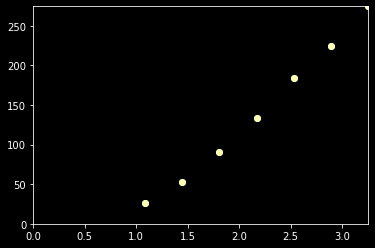

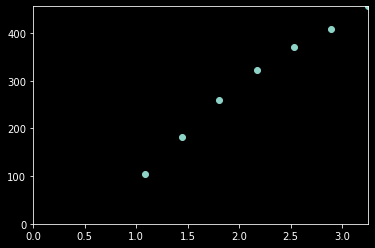

In [5]:
T0s = []
Vfs = []
Vs = []
for duty, (a, b, c) in D['fwd'].items():
    V = V0 * duty / 2048
    # Ki.append(-a * c / V)
    T0s.append(b * c)
    Vfs.append(a)
    Vs.append(V)

Ki, F0 = np.polyfit(Vs, T0s, 1)
plt.scatter(Vs, T0s)
Kv, Kv0 = np.polyfit(Vs, Vfs, 1)
plt.scatter(Vs, T0s)
plt.xlim([0, np.amax(Vs)])
plt.ylim([0, np.amax(T0s)])
plt.figure()
plt.scatter(Vs, Vfs)
plt.xlim([0, np.amax(Vs)])
plt.ylim([0, np.amax(Vfs)])
print(Ki, Kv, Kv0, F0)

B: -0.154; F0: 21.428


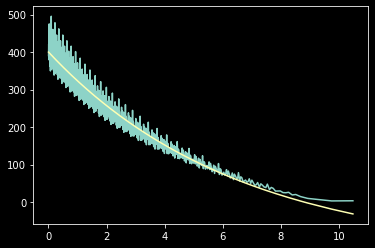

In [21]:
D_ = []
with open('20210608/slowdown', 'r') as f:
    f.__next__()
    for l in f:
        D_ += [int(a) for a in re.sub(r'[{}]', '', l.strip()).split(',')]
D_ = np.array(D_)
X = np.cumsum(D_) * 1E-6 * (1 << 4)
V = TICK2RADS / D_
t = expfit(V, X)
(a, b, c) = t
plt.plot(X, V)
plt.plot(X, a + b * np.exp(c * X))
print('B: %.3f; F0: %.3f' % (c, a * c))